In [1]:
import pandas as pd
df = pd.read_csv("surface_n2o_compilation.csv")
df

,cruise,date,year,month,day,latitude,longitude,depth,n2o_ppb,n2o_nM,dn2o_ppb,atmPressure,temperature,salinity
0,JOINT II Leg 0,1976-03-08,1976,3,8,22.0200,250.9200,0.0,524.622831,11.5900,224.739949,1.001743,21.900,34.664284
1,JOINT II Leg 0,1976-03-10,1976,3,10,15.6150,256.8200,0.0,365.587598,6.8200,65.701757,0.999566,27.700,33.795834
2,JOINT II Leg 0,1976-03-12,1976,3,12,9.5400,262.5600,0.0,435.085126,8.4100,135.196326,0.998316,26.400,33.940033
3,JOINT II Leg 0,1976-03-13,1976,3,13,5.1500,266.6200,0.0,462.589867,8.2900,162.699587,0.997575,29.200,32.883614
4,JOINT II Leg 0,1976-03-16,1976,3,16,-3.2200,274.7600,0.0,431.508109,8.0700,131.613389,0.997930,27.400,34.689255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158193,M100-1,2013-09-29,2013,9,29,-21.0882,12.4816,0.0,398.871600,10.5164,73.004470,1.002503,15.536,33.940000
158194,M100-1,2013-09-29,2013,9,29,-21.0902,12.4828,0.0,399.690200,10.5318,73.823095,1.002501,15.535,33.902000
158195,M100-1,2013-09-29,2013,9,29,-21.0937,12.4851,0.0,400.187600,10.5330,74.320540,1.002501,15.539,34.016000
158196,M100-1,2013-09-29,2013,9,29,-21.0955,12.4862,0.0,400.550400,10.5594,74.683363,1.002500,15.539,33.940000


In [ ]:
df['cruise'].unique().size

176

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

df = pd.read_csv("surface_n2o_compilation.csv")

features = ["latitude", "longitude", "depth", "atmPressure", "temperature", "salinity", "month"]
X = df[features]
y = df["dn2o_ppb"]

# split by cruises
cruises = df['cruise'].unique()

np.random.seed(42)  # For reproducibility

test_cruises = np.random.choice(cruises, size=int(len(cruises) * 0.3), replace=False)
train_cruises = [cruise for cruise in cruises if cruise not in test_cruises]
# Create training and test sets based on cruises
train_mask = df['cruise'].isin(train_cruises)
test_mask = df['cruise'].isin(test_cruises)
# Create training and test sets
X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples.\nPercentage of test samples: {len(X_test) / len(df) * 100:.2f}%")

model = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True, n_jobs=-1)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print("Test set:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


y_oob_pred = model.oob_prediction_

print("\nOut-of-Bag (OOB) predictions on training set:")
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_oob_pred)))
print("R²:", r2_score(y_train, y_oob_pred))

Training on 126316 samples, testing on 31882 samples.
Percentage of test samples: 20.15%
Test set:
RMSE: 352.1635799084037
R²: -3.4345178743935296

Out-of-Bag (OOB) predictions on training set:
RMSE: 155.23984270067675
R²: 0.7764669072944255


Training on 122174 samples, testing on 31513 samples.
Percentage of test samples: 20.50%
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Test set:
RMSE (ppb): 59.860
R² (ppb): -0.138
RMSE (natm): 5.986e+01

Out-of-Bag (OOB) predictions on training set:
RMSE (ppb): 13.453
R² (ppb): 0.983


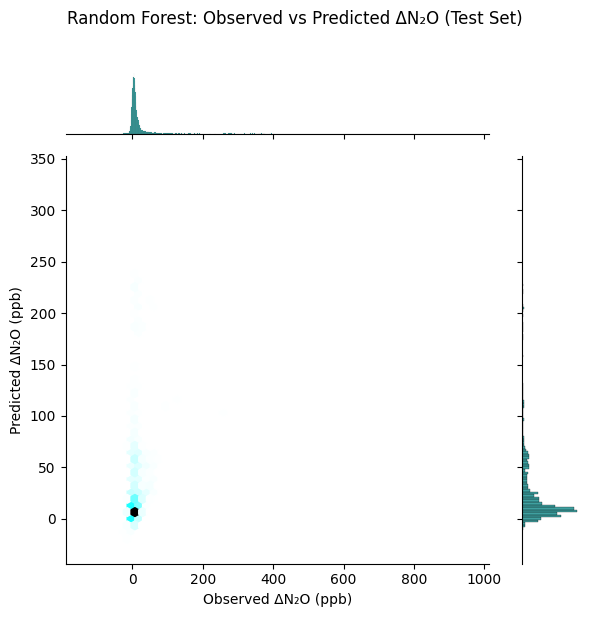

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("surface_n2o_compilation.csv")
features = ["latitude", "longitude", "depth", "atmPressure", "temperature", "salinity", "month"]
target = "dn2o_ppb"


df = df.dropna(subset=features + [target])

# remove outliers using z-score
df = df[(np.abs(zscore(df[features + [target]])) < 3).all(axis=1)]

# feature engineering
df["temp_sal"] = df["temperature"] * df["salinity"]
df["depth_pressure"] = df["depth"] * df["atmPressure"]
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)


features += ["temp_sal", "depth_pressure", "month_sin", "month_cos"]

X = df[features]
y = df["dn2o_ppb"]

# split by cruises
cruises = df['cruise'].unique()

np.random.seed(42)  # For reproducibility

test_cruises = np.random.choice(cruises, size=int(len(cruises) * 0.3), replace=False)
train_cruises = [cruise for cruise in cruises if cruise not in test_cruises]
# Create training and test sets based on cruises
train_mask = df['cruise'].isin(train_cruises)
test_mask = df['cruise'].isin(test_cruises)
# Create training and test sets
X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples.\nPercentage of test samples: {len(X_test) / len(df) * 100:.2f}%")


param_grid = {
    "n_estimators": [200],
    "max_depth": [None, 20],
    "min_samples_split": [2, 5],
    "max_features": ["sqrt"]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1),
                    param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid.fit(X_train, y_train)
model = grid.best_estimator_


y_pred = model.predict(X_test)
rmse_ppb = np.sqrt(mean_squared_error(y_test, y_pred))
r2_ppb = r2_score(y_test, y_pred)

# Convert to natm using atmospheric pressure
#atm_pressure_test = X_test["atmPressure"].values
#y_test_natm = y_test * 1e-9 * atm_pressure_test
#y_pred_natm = y_pred * 1e-9 * atm_pressure_test
rmse_natm = np.sqrt(mean_squared_error(y_test, y_pred))

# OOB score
y_oob_pred = model.oob_prediction_
rmse_oob = np.sqrt(mean_squared_error(y_train, y_oob_pred))
r2_oob = r2_score(y_train, y_oob_pred)


print("Test set:")
print(f"RMSE (ppb): {rmse_ppb:.3f}")
print(f"R² (ppb): {r2_ppb:.3f}")
print(f"RMSE (natm): {rmse_natm:.3e}")

print("\nOut-of-Bag (OOB) predictions on training set:")
print(f"RMSE (ppb): {rmse_oob:.3f}")
print(f"R² (ppb): {r2_oob:.3f}")

sns.jointplot(x=y_test, y=y_pred, kind="hex", color="teal")
plt.xlabel("Observed ΔN₂O (ppb)")
plt.ylabel("Predicted ΔN₂O (ppb)")
plt.suptitle("Random Forest: Observed vs Predicted ΔN₂O (Test Set)", y=1.02)
plt.tight_layout()
plt.show()


In [3]:
from torch import nn
import torch
import pandas as pd
import numpy as np

class FullSequenceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.norm = nn.LayerNorm(hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.norm(out)
        out = self.fc(out)
        return out.squeeze(-1)
    

df = pd.read_csv("surface_n2o_compilation.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

features = ["latitude", "longitude", "depth", "atmPressure", "temperature", "salinity", "month"]
X = df[features]
y = df["dn2o_ppb"]

# split by cruises
cruises = df['cruise'].unique()

np.random.seed(42)  # For reproducibility

test_cruises = np.random.choice(cruises, size=int(len(cruises) * 0.3), replace=False)
train_cruises = [cruise for cruise in cruises if cruise not in test_cruises]
# Create training and test sets based on cruises
train_mask = df['cruise'].isin(train_cruises)
test_mask = df['cruise'].isin(test_cruises)

# Create training and test sets
X_train = torch.tensor(X[train_mask].to_numpy()).to(device).float().unsqueeze(1)  # Add sequence dimension
X_test = torch.tensor(X[test_mask].to_numpy()).to(device).float().unsqueeze(1)  # Add sequence dimension
y_train = torch.tensor(y[train_mask].to_numpy()).to(device).float()
y_test = torch.tensor(y[test_mask].to_numpy()).to(device).float()

print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples.\nPercentage of test samples: {len(X_test) / len(df) * 100:.2f}%")

model = FullSequenceLSTM(input_size=len(features), hidden_size=128, num_layers=3, dropout=0.2)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.05, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)
criterion = torch.nn.MSELoss()

best_loss = float("inf")
counter, patience = 30, 0
epochs = 250
grad_clip = 1.0

for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    scheduler.step()

    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "best_gat_model.pth")
        patience = 0
    else:
        patience += 1

    if epoch % 20 == 0 or patience == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.6f}")
    if patience > counter:
        print("Early stopping.")
        break


model.load_state_dict(torch.load("best_gat_model.pth"))
model.eval()
with torch.no_grad():
    preds = model(X_test).cpu().numpy()
    y_true = y_test.cpu().numpy()

rmse = np.sqrt(np.mean((preds - y_true) ** 2))
r2 = 1 - np.sum((preds - y_true) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

print(f"\nFinal GAT Test RMSE: {rmse:.2f} ppb")
print(f"Final GAT Test R²: {r2:.4f}")

y_pred = model.predict(X_test)
print("Test set:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


y_oob_pred = model.oob_prediction_

print("\nOut-of-Bag (OOB) predictions on training set:")
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_oob_pred)))
print("R²:", r2_score(y_train, y_oob_pred))

Training on 126316 samples, testing on 31882 samples.
Percentage of test samples: 20.15%


/home/jadwiga/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([126316])) that is different to the input size (torch.Size([126316, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: [enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 63822927424 bytes. Error code 12 (Cannot allocate memory)